In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def mse(y_true, y_pred):
    return (tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Feature and target columns
x_cols = dataset.columns
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
x_cols = x_cols[~x_cols.isin(y_cols)]


2025-03-21 12:55:51.111904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742541951.162793   15249 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742541951.177602   15249 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742541951.283935   15249 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742541951.283974   15249 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742541951.283977   15249 computation_placer.cc:177] computation placer alr

In [3]:
x_cols

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q',
       'profile_id', 'i_s', 'u_s',
       ...
       'i_d_ew_rolling_std_7200', 'i_q_ew_rolling_std_7200',
       'pm_ew_rolling_std_7200', 'stator_yoke_ew_rolling_std_7200',
       'stator_tooth_ew_rolling_std_7200',
       'stator_winding_ew_rolling_std_7200', 'profile_id_ew_rolling_std_7200',
       'i_s_ew_rolling_std_7200', 'u_s_ew_rolling_std_7200',
       'P_el_ew_rolling_std_7200'],
      dtype='object', length=191)

In [4]:
X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
lookback = 128

# Reshape function for RNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[:num_samples].reshape((num_samples // lookback, lookback, y.shape[1]))  # Match X's shape
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)


In [5]:
import numpy as np

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())


NaN in X_train: 46236517
NaN in y_train: 1191788
Inf in X_train: 0
Inf in y_train: 0


In [6]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

NaN in X_train: 0
NaN in y_train: 0
Inf in X_train: 0
Inf in y_train: 0


In [7]:
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

print("NaN in X_test:", np.isnan(X_test).sum())
print("NaN in y_test:", np.isnan(y_test).sum())
print("Inf in X_test:", np.isinf(X_test).sum())
print("Inf in y_test:", np.isinf(y_test).sum())

NaN in X_test: 0
NaN in y_test: 0
Inf in X_test: 0
Inf in y_test: 0


In [8]:
X_val = np.nan_to_num(X_val)
y_val = np.nan_to_num(y_val)

print("NaN in X_val:", np.isnan(X_val).sum())
print("NaN in y_val:", np.isnan(y_val).sum())
print("Inf in X_val:", np.isinf(X_val).sum())
print("Inf in y_val:", np.isinf(y_val).sum())

NaN in X_val: 0
NaN in y_val: 0
Inf in X_val: 0
Inf in y_val: 0


In [10]:
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanSquaredError

# Ensure y has the same batch size as X
y_train = y_train[:X_train.shape[0]]
y_val = y_val[:X_val.shape[0]]
y_test = y_test[:X_test.shape[0]]

# No need to tile y_train, y_val, and y_test; just reshape to match batch size
target_param_size = y_train.shape[-1]

# Reshape targets to match model output shape
y_train = np.tile(y_train, (1, 128, 1))  # (batch_size, 128, 4)
y_val = np.tile(y_val, (1, 128, 1))
y_test = np.tile(y_test, (1, 128, 1))



def build_rnn_model(input_shape, arch='lstm', n_layers=1, n_units=4,
                    kernel_reg=0.1, activity_reg=3e-5, recurrent_reg=0.01,
                    bias_reg=1e-5, dropout_rate=0.3, optimizer='adam',
                    gauss_noise_std=0.01, lr_rate=0.001, loss='mse',
                    target_param_size=4):


    arch_dict = {'lstm': layers.LSTM, 'gru': layers.GRU, 'rnn': layers.SimpleRNN}
    opts_map = {'adam': optimizers.Adam, 'nadam': optimizers.Nadam,
                'adamax': optimizers.Adamax, 'sgd': optimizers.SGD,
                'rmsprop': optimizers.RMSprop}

    rnn_cfg = {
        'units': int(n_units),
        'kernel_regularizer': regularizers.l2(kernel_reg),
        'activity_regularizer': regularizers.l2(activity_reg),
        'recurrent_regularizer': regularizers.l2(recurrent_reg),
        'bias_regularizer': regularizers.l2(bias_reg),
        'dropout': dropout_rate,
        'recurrent_dropout': dropout_rate,
        'return_sequences': True,
        'input_shape': input_shape
    }

    ANN = arch_dict.get(arch, layers.LSTM)  # Default to LSTM if arch is unknown

    x = layers.Input(shape=input_shape)
    y = ANN(**rnn_cfg)(x)
    y = layers.GaussianNoise(gauss_noise_std)(y)
    y = layers.TimeDistributed(layers.Dense(target_param_size))(y)

    model = models.Model(inputs=x, outputs=y)

    opt = opts_map[optimizer](learning_rate=lr_rate)
    model.compile(optimizer=opt, loss=loss, metrics=[MeanSquaredError()]) 
    model.summary()

    return model

input_shape = (lookback, len(x_cols))
model = build_rnn_model(input_shape=input_shape,
                        arch='lstm',
                        n_layers=1,
                        n_units=4,
                        kernel_reg=0.1,
                        activity_reg=3e-5,
                        recurrent_reg=0.01,
                        bias_reg=1e-5,
                        dropout_rate=0.3,
                        optimizer='adam',
                        gauss_noise_std=0.01,
                        lr_rate=0.001,
                        loss='mse',
                        target_param_size=target_param_size)


callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6)
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=125,
    batch_size=128,
    shuffle=False,
    callbacks=callbacks
)

test_loss, test_mse = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.6f}, Test MSE: {test_mse:.6f}')


model.save('rnn_time_series_model.h5')

import json

with open("training_history_rnn_time_series_model.json", "w") as f:
    json.dump(history.history, f)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 191)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128, 4)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 128, 4)         │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 128, 4)         │            20 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,156 (12.33 KB)

 Trainable params: 3,156 (12.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/125


2025-03-21 12:58:30.989705: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1017134592 exceeds 10% of free system memory.


82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 3.4286 - mean_squared_error: 0.7060 - val_loss: 2.5326 - val_mean_squared_error: 1.6407 - learning_rate: 0.0010
Epoch 2/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.2659 - mean_squared_error: 0.4906 - val_loss: 1.6927 - val_mean_squared_error: 1.4281 - learning_rate: 0.0010
Epoch 3/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.6765 - mean_squared_error: 0.3917 - val_loss: 1.5642 - val_mean_squared_error: 1.4181 - learning_rate: 0.0010
Epoch 4/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.5057 - mean_squared_error: 0.3535 - val_loss: 1.5197 - val_mean_squared_error: 1.4149 - learning_rate: 0.0010
Epoch 5/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.4454 - mean_squared_error: 0.3410 - val_loss: 1.4926 - val_mean_squared_error: 1.4123 - learning_rate: 0.0010
Epoch 6/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.4148 - mean_squared_error: 0.3350 - val_loss: 1.4751 - val_mean_squared_error: 1.4103 - le

Test Loss: 1.387014, Test MSE: 1.386836


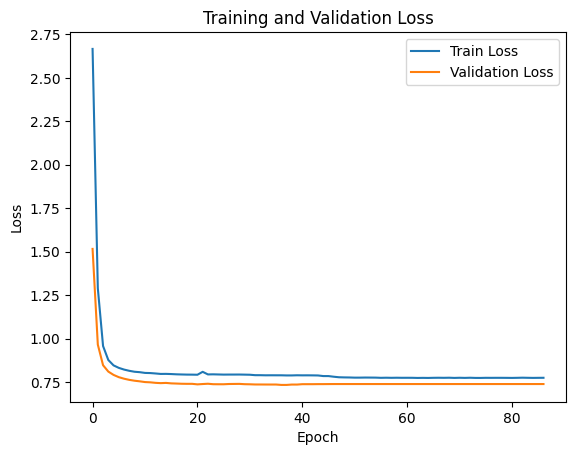

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


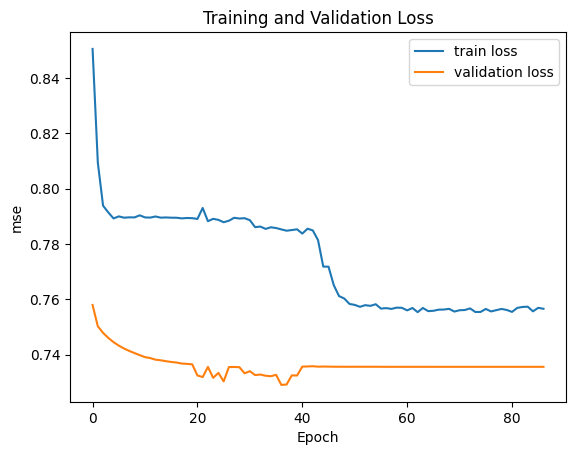

In [ ]:
plt.figure()
plt.plot(history.history['mse'], label='train loss')
plt.plot(history.history['val_mse'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

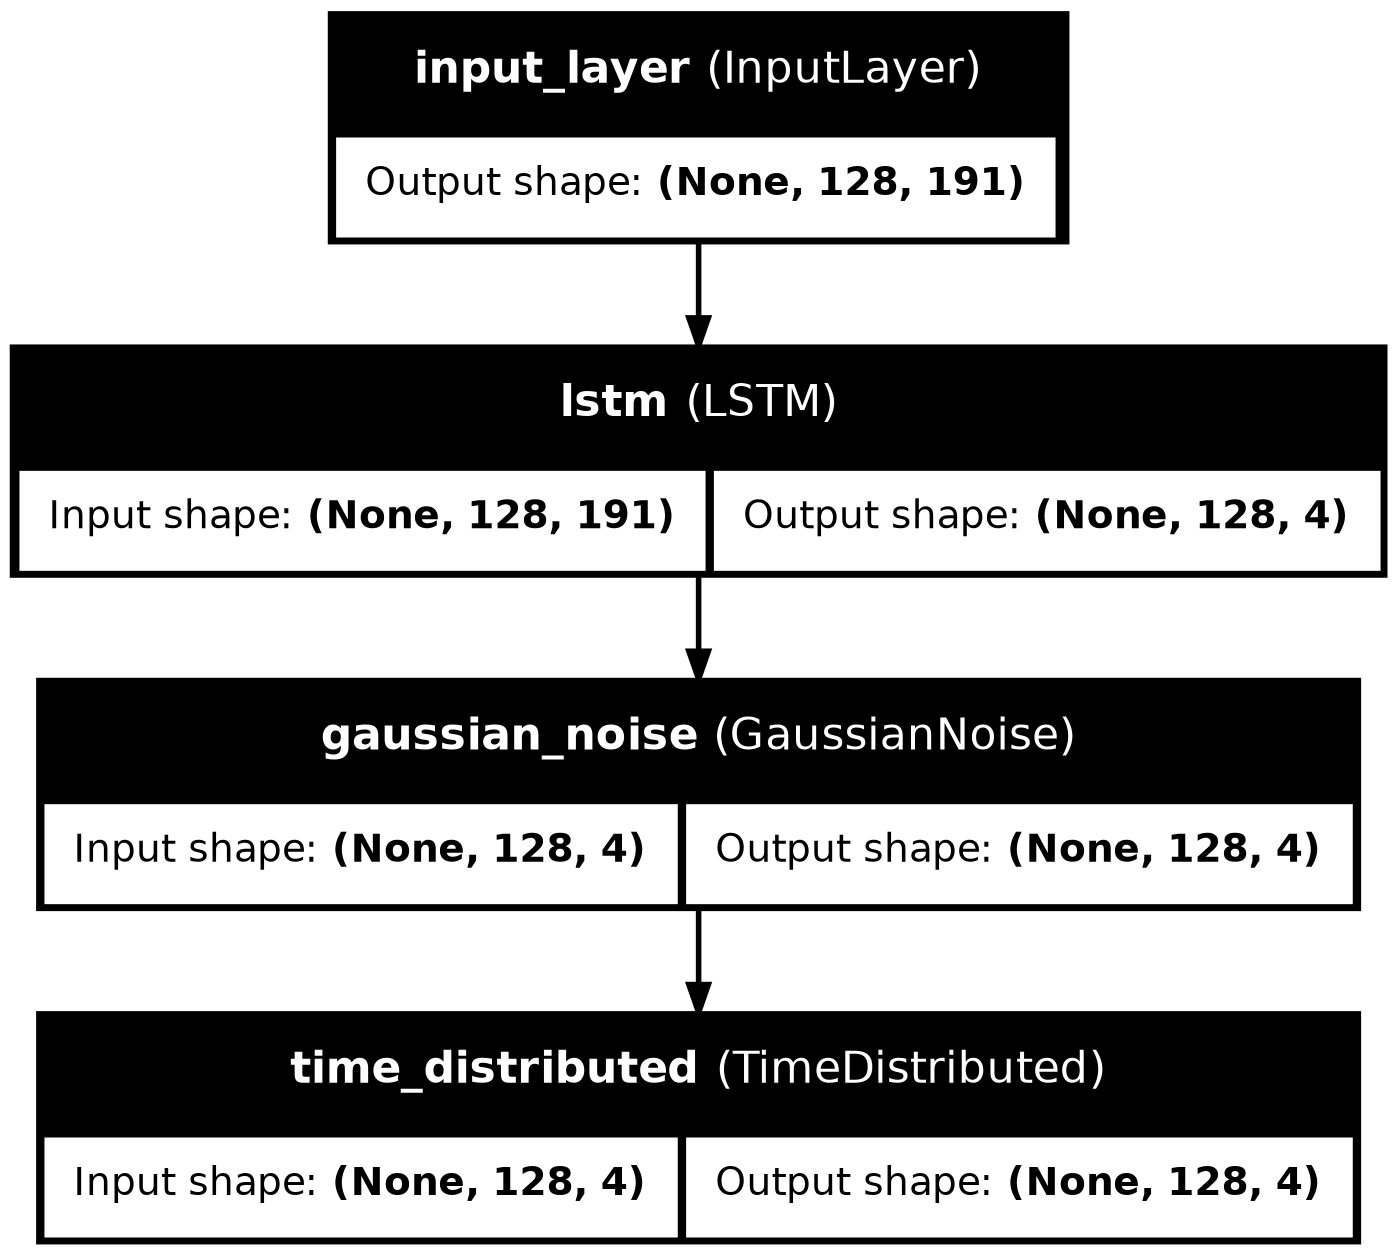

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='rnn_model.png')
